# Predator Prey

![PINNs](../images/lynx.jpg)

[Source](https://www.gov.nl.ca/fal/wildlife/snp/programs/education/animal-facts/mammals/lynx/)

The _Predator-Prey_ model is defined as follows:

$$
\dfrac{dx}{dt} = \alpha x - \beta xy \\
\dfrac{dy}{dt} = -\gamma y + \delta xy
$$

- The prey population have an unlimited supply of food at all times.
- In the absence of the predators, the prey population $x$ would grow proportionally to its size as $\dot{x}_1 = \alpha x$
- In the absence of the prey, the predator population $y$ would decay proportionally to its size as $\dot{x}_2 = -\gamma y$
- When both populations are present, a growth in the predator and decline in the prey population each at the respective rates proportional to the number of encounters between individuals in each population (denoted by $\delta y x$ and $-\beta x y$, respectively.)

Consider the following scenario. Imagine a researcher sampled daily data, denoted by, $x_{observed} = (x(t_1), x(t_2) , \ldots, x(t_n))$ and $y_{observed} = (y(t_1), y(t_2) , \ldots, y(t_n))$ where $t_1, t_2, \ldots, t_n$ represents time.

__Goal__: Estimate the real values of $\alpha$, $\beta$, $\gamma$ and $\delta$ for this sampled data. This is called an _Inverse Problem_ but some authors also called this sort of approaches as _Data-Driven Discovery_. We will use PINNs for this purpose and you will notice we only need to add some extra features compared to the last lesson.

In [1]:
# !pip install deepxde

In [2]:
# import os
# os.environ["DDE_BACKEND"] = "pytorch"

In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde

from scipy.integrate import solve_ivp

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Training Data

The train data will be generated by ourserlves, so we will have a better understading of the error. Let's choose a time interval, initial conditions and parameters.

In [4]:
t_initial, t_final = 0, 10  # Equivalent to 10 days
x0 = 1.2
y0 = 0.8

alpha_real = 2 / 3
beta_real = 4 / 3
gamma_real = 1
delta_real = 1

parameters_real = {
  "alpha": alpha_real,
  "beta": beta_real,
  "gamma": gamma_real,
  "delta": delta_real
}  # We will use this later for study errors

We will generate synthetic data, which will allows us to study errors since we have control over the real parameters $\alpha$, $\beta$, $\gamma$ and $\delta$.

In [5]:
def generate_data(
  t,
  x0,
  y0,
  alpha,
  beta,
  gamma,
  delta
):

  def func(t, Y):
    # ODE system
    x, y = Y
    dx_dt = alpha * x - beta * x * y
    dy_dt = - gamma * y  + delta * x * y
    return dx_dt, dy_dt

  Y0 = [x0, y0] # Initial conditions
  t = t.flatten()
  t_span = (t[0], t[-1])  # Time-span
  sol = solve_ivp(func, t_span, Y0, t_eval=t)
  return sol.y.T


/tmp/ipykernel_14190/2198912916.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


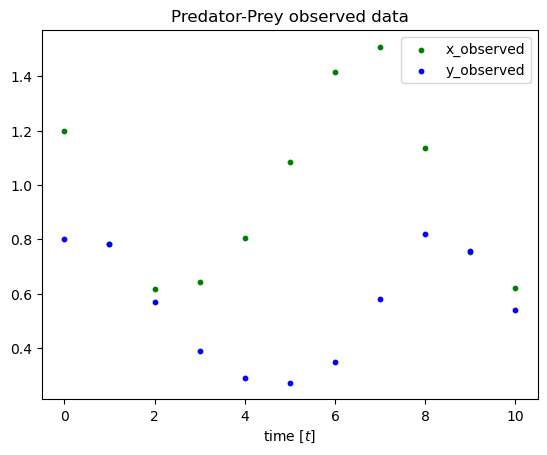

In [6]:
t_observed = np.linspace(t_initial, t_final, 11).reshape(-1, 1)
Y_observed = generate_data(t_observed, x0, y0, alpha_real, beta_real, gamma_real, delta_real)

fig, ax = plt.subplots()
ax.scatter(t_observed, Y_observed[:, 0:1], color="green", s=10, label="x_observed")
ax.scatter(t_observed, Y_observed[:, 1:2], color="blue", s=10, label="y_observed")
ax.legend()
ax.set(
  title="Predator-Prey observed data",
  xlabel="time [$t$]"
)
fig.show()

## PINNs Data-Driven Discovery

PINNs can solve differential equations expressed, in the most general form, like:

$$
\begin{align*}
\mathcal{F}(u(z); \lambda) &= f(z) \quad z \text{ in } \Omega \\
\mathcal{B}(u(z)) &= g(z) \quad z \text{ in } \partial \Omega
\end{align*}
$$ 

defined on the domain $\Omega \subset \mathbb{R}^d$ with the boundary $\partial \Omega$. Where
- $z := (x_1, x_2, \ldots, t)^\top$ indicated the space-time coordinate vector,
- $u$ the unknown function,
- $\lambda$ the parameters related to the physics,
- $\mathcal{F}$ the non-linear differential operator,
- $f$ the function identifying the data of the problem,
- $\mathcal{B}$ the operator indicating arbitrary initial or boundary conditions, and
- $g$ the boundary function.

In the PINN methodology, $u(z)$ is computationally predicted by a NN, parametrized by a set of parameters $\theta$, giving rise to an approximation
$$
\hat{u}_\theta(z) \approx u(z)
$$

The optimization problem we want to deal with it is

$$
\min_\theta \; \omega_\mathcal{F} \mathcal{L}_\mathcal{F}(\theta) + \omega_\mathcal{B} \mathcal{L}_\mathcal{B}(\theta) + \omega_{\text{data}} \mathcal{L}_{\text{data}}(\theta)
$$

this is three weighted loss functions, each one depending on
- $\mathcal{L}_\mathcal{F}$, differential equation, 
- $\mathcal{L}_\mathcal{B}$, boundary conditions, and
- $\mathcal{L}_{\text{data}}$, (eventually) some known data.

![PINNs](../images/info_pinn.png)

[Source](https://link.springer.com/article/10.1007/s10915-022-01939-z)

Now, coming back to our Predator-Prey problem, we will _forget_ for a minute about the real values of $\alpha$, $\beta$, $\gamma$ and $\delta$ since the goal of this lesson is to learn how to estimate these parameters. Let's start defining them in a way that our code knows they have to be learned.

In [7]:
# Pick some initial guess
alpha = dde.Variable(0.0)
beta = dde.Variable(0.0)
gamma = dde.Variable(0.0)
delta = dde.Variable(0.0)

Now we have to define the residuals and initial conditions in the same way the forward approximation (previous module).

In [ ]:
def ode(t, Y):
  x = Y[:, 0:1]
  y = Y[:, 1:2]
  dx_dt = dde.grad.jacobian(Y, t, i=0)
  dy_dt = dde.grad.jacobian(Y, t, i=1)
  
  return [
    dx_dt - alpha * x + beta * x * y,
    dy_dt + gamma * y  - delta * x * y
  ]

We need to define the domain and the initial conditions

In [9]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

def boundary(_, on_initial):
  return on_initial

ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

We can use the observed data `t_observed` and `Y_observed` to use for the training process. We use the special class `PointSetBC' to declare the observed data.

In [10]:
x_observed = dde.icbc.PointSetBC(t_observed.reshape(-1, 1), Y_observed[:, 0:1], component=0)
y_observed = dde.icbc.PointSetBC(t_observed.reshape(-1, 1), Y_observed[:, 1:2], component=1)

Be careful! Note that `component=0` is associated with the variable $x$ every time, defining the gradients, initial conditions and observed data. Same for `component=1` which corresponds to the variable $y$.

The data object is similar but we include the observed data as well in the list of conditions. But also note that we can add the observed data as train points with the argument `anchors`.

In [11]:
data = dde.data.PDE(
  geom,
  ode,
  [ic_x, ic_y, x_observed, y_observed],
  num_domain=512,  # Interior Points
  num_boundary=2,
  anchors=t_observed,
)

Now we can define our neural network architecture. We will use a simple Multi-Layer Perceptron ('FNN'), with $\tanh$ as activation function.

In [12]:
neurons = 64
layers = 3
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

## Training

We combine the elements from the differential equations ('data') and the network architecture ('net') into a 'model' object. Here we also define the optimizer to be used ('adam'), the learning rate ('lr') and most importantly, we have to tell our model it has to learn the ODE parameters ($\alpha$, $\beta$, $\gamma$ and $\delta$) using `external_trainable_variables`.

In [13]:
model = dde.Model(data, net)
model.compile(
  "adam",
  lr=0.001,
  external_trainable_variables=[alpha, beta, gamma, delta]
)

Compiling model...


/home/aoguedao/miniforge3/envs/sciml-torch/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


'compile' took 0.704824 s



In order to study the convergence of the learning process related to the parameters we want to estimate we need a separate file where we can store these estimations. The file `variables.dat` will store ours estimations of $\alpha$, $\beta$, $\gamma$ and $\delta$ each 100 iterations.

In [14]:
variable = dde.callbacks.VariableValue(
  [alpha, beta, gamma, delta],
  period=100,
  filename="predator-prey-variables.dat"
)

The training process is a method from the 'model' object. Do not forget to add this variable in the training process using `callbacks=[variable]`. 

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.95e-03, 1.42e-02, 1.44e+00, 6.40e-01, 1.78e+00, 1.26e+00]    [4.95e-03, 1.42e-02, 1.44e+00, 6.40e-01, 1.78e+00, 1.26e+00]    []  
500       [1.67e-02, 7.31e-03, 2.25e-04, 3.26e-06, 2.14e-02, 1.13e-02]    [1.67e-02, 7.31e-03, 2.25e-04, 3.26e-06, 2.14e-02, 1.13e-02]    []  
1000      [7.07e-03, 7.65e-03, 8.17e-05, 4.62e-07, 3.74e-03, 1.22e-03]    [7.07e-03, 7.65e-03, 8.17e-05, 4.62e-07, 3.74e-03, 1.22e-03]    []  
1500      [1.42e-03, 1.69e-03, 1.47e-05, 3.00e-06, 4.48e-04, 3.35e-04]    [1.42e-03, 1.69e-03, 1.47e-05, 3.00e-06, 4.48e-04, 3.35e-04]    []  
2000      [3.96e-04, 2.93e-04, 9.55e-07, 5.46e-07, 7.65e-05, 1.07e-04]    [3.96e-04, 2.93e-04, 9.55e-07, 5.46e-07, 7.65e-05, 1.07e-04]    []  
2500      [9.05e-05, 2.50e-05, 1.88e-07, 3.64e-07, 1.94e-05, 1.30e-05]    [9.05e-05, 2.50e-05, 1.88e-07, 3.64e-07, 1

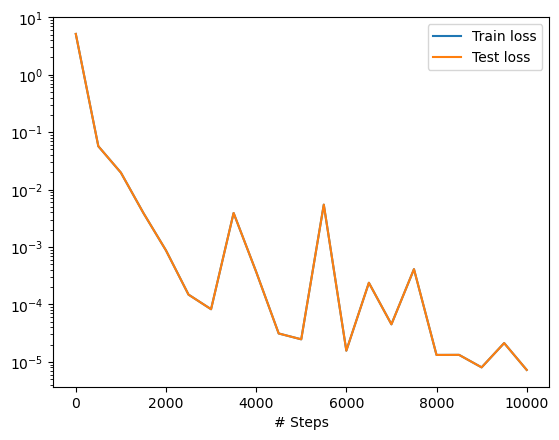

In [15]:
losshistory, train_state = model.train(iterations=10_000, display_every=500, callbacks=[variable])
dde.utils.external.plot_loss_history(losshistory)  # Loss history

We can plot the data as well but it is not the main point of this lesson.

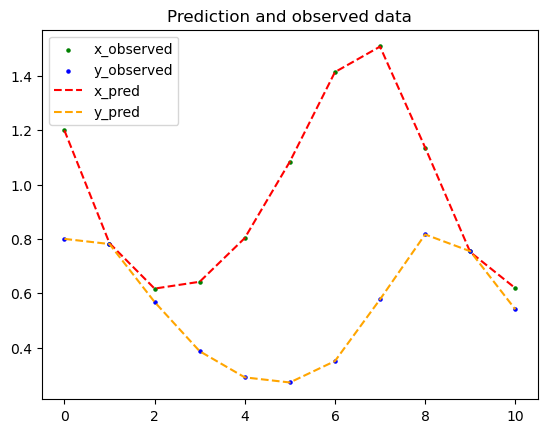

In [16]:
fig, ax = plt.subplots()

# Observed data
ax.scatter(t_observed, Y_observed[:, 0:1], color="green", s=5, label="x_observed")
ax.scatter(t_observed, Y_observed[:, 1:2], color="blue", s=5, label="y_observed")

# Model prediction
sol_pred = model.predict(t_observed.reshape(-1, 1))
x_pred = sol_pred[:, 0:1]
y_pred = sol_pred[:, 1:2]

# Predicted curves
ax.plot(t_observed, x_pred, color="red", linestyle="dashed", label="x_pred")
ax.plot(t_observed, y_pred, color="orange", linestyle="dashed", label="y_pred")

ax.set_title("Prediction and observed data")
ax.legend()

plt.show()

## Learning History

We need to open the file `variables.dat` and create arrays for each parameter. Do not worry about the next piece of code, it will only return a dictionary where keys are the name of the parameters and values are their learning history. 

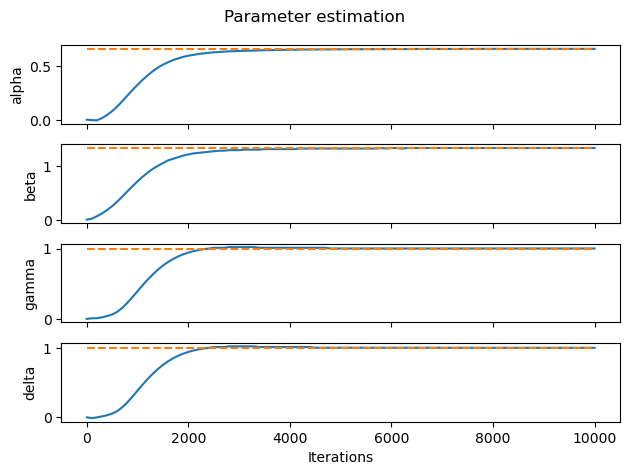

In [17]:
lines = open("predator-prey-variables.dat", "r").readlines()
raw_parameters_pred_history = np.array(
  [
    np.fromstring(
      min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
      sep=",",
    )
    for line in lines
  ]
)
iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
  name: raw_parameters_pred_history[:, i]
  for i, name in enumerate(parameters_real.keys())
}

n_callbacks, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True)
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
  ax.plot(iterations, parameters_pred_history[parameter] , "-")
  ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
  ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()

It took less than 5000 iterations to get a really good approximation for each variable! Now we can calculate the relative error for each parameter since we already know the real value.

In [18]:
alpha_pred, beta_pred, gamma_pred, delta_pred = variable.value

print(f"alpha - real: {alpha_real:4f} - predicted: {alpha_pred:4f} - relative error: {np.abs((alpha_real - alpha_pred) / alpha_real):4f}")
print(f"beta - real: {beta_real:4f} - predicted: {beta_pred:4f} - relative error: {np.abs((beta_real - beta_pred) / beta_real):4f}")
print(f"gamma - real: {gamma_real:4f} - predicted: {gamma_pred:4f} - relative error: {np.abs((gamma_real - gamma_pred) / gamma_real):4f}")
print(f"delta - real: {delta_real:4f} - predicted: {delta_pred:4f} - relative error: {np.abs((delta_real - delta_pred) / delta_real):4f}")

alpha - real: 0.666667 - predicted: 0.664021 - relative error: 0.003969
beta - real: 1.333333 - predicted: 1.328433 - relative error: 0.003675
gamma - real: 1.000000 - predicted: 1.000124 - relative error: 0.000124
delta - real: 1.000000 - predicted: 0.998975 - relative error: 0.001025


## Project 1

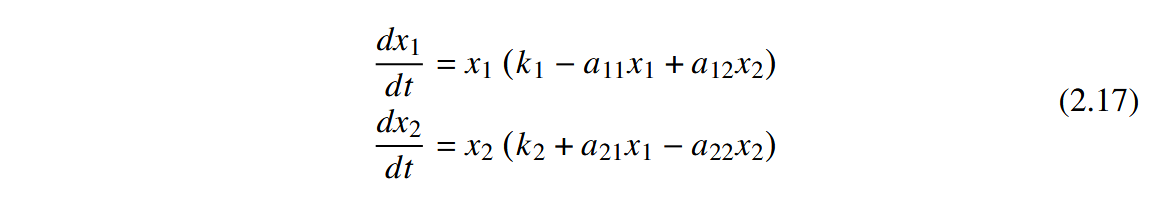

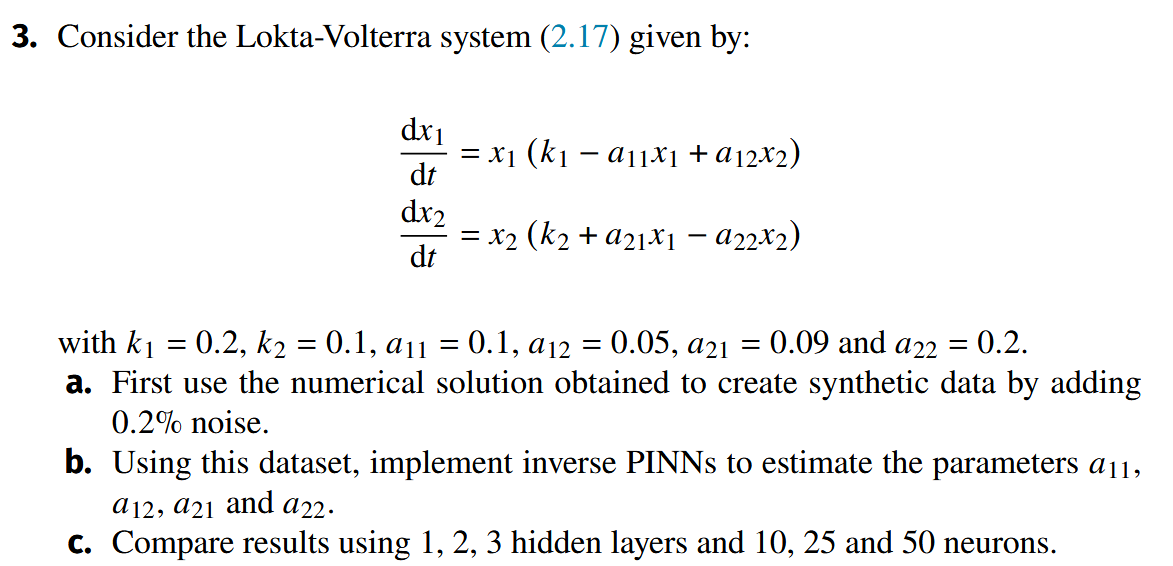

## Project 2

We can combine classic ODE assigments with modern data-driven methods as well.

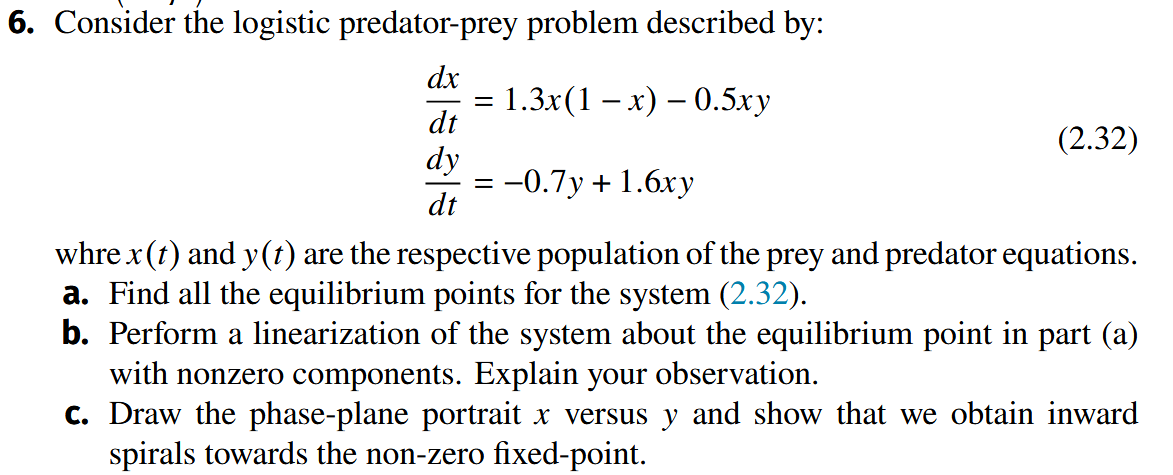

Use the real dataset of lynx and hare (https://raw.githubusercontent.com/john-s-butler-dit/Predator-Prey-for-Young-Minds/refs/heads/master/hare_lynx_data.csv) to estimate the parameters of the predator-prey model using PINNs. Try different architectures, initial values, iterations, etc. Comment your results.


## More Examples

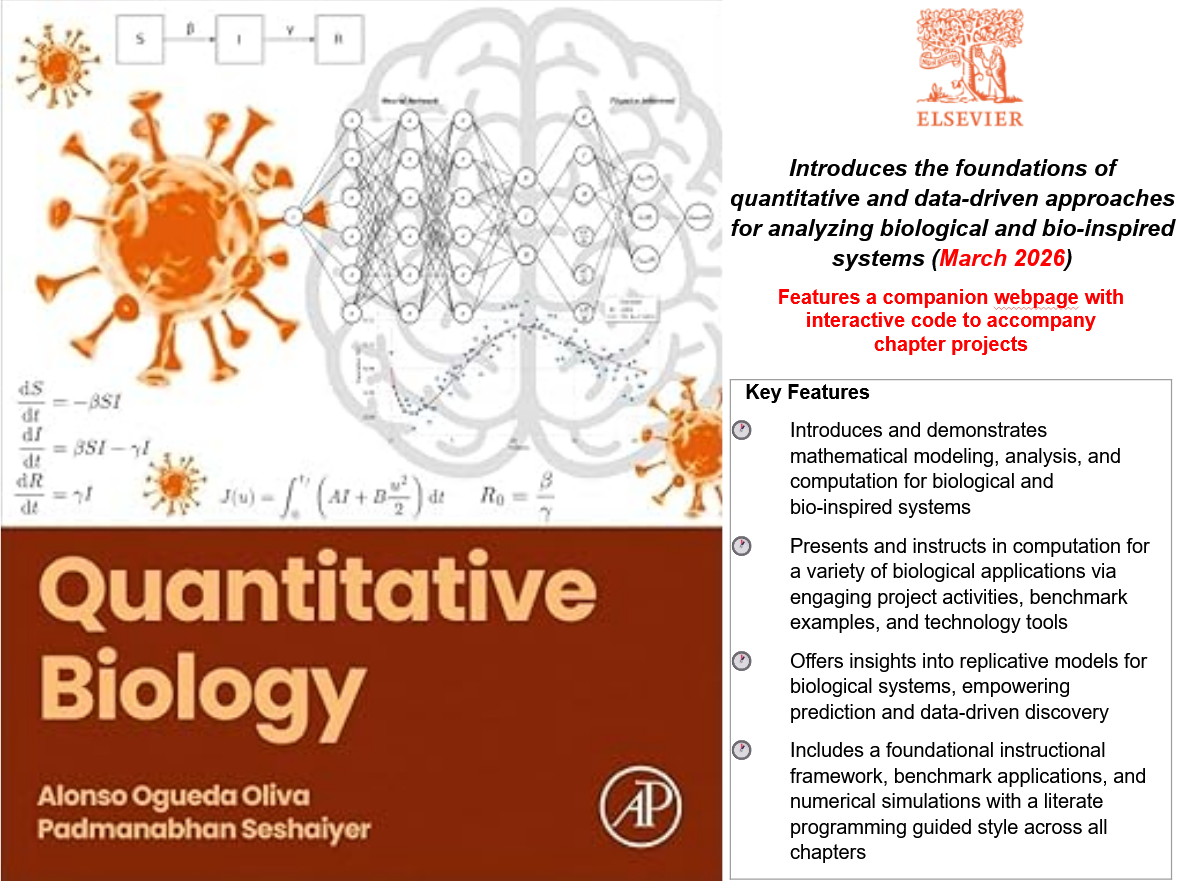